In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

C:\Users\yc180\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 4. Estimate how well the PE_face and PE_name explain the RTs (among other factors)
* calculate PE_feac and PE_name
* construct a design matrix containing all other explanatory factors + PE_face and PE_name
* Performa a multiple regressions and obtain the beta coefficient for PE_face and PE_name

In [2]:
df_gp = pd.read_pickle('df_wCP_v3.pkl')
newCol = ['bkType','runId','faceRep','nameRep','fullRepAlt','PE_face','PE_name']
for i in newCol:
    df_gp.loc[:, i] = None
df_gp['PE_face'] = abs(df_gp.conflict-df_gp.CP_face)
df_gp['PE_name'] = abs(df_gp.conflict-df_gp.CP_name)
df_gp.head()

,sbjId,faceId,nameId,conflict,zRT,RT,CP_face,CP_name,bkType,runId,faceRep,nameRep,fullRepAlt,PE_face,PE_name
0,1,8,8,0,-0.240255,577.219800,0.50,0.500,None,None,None,None,None,0.50,0.500
1,1,5,5,0,0.820208,665.302282,0.50,0.500,None,None,None,None,None,0.50,0.500
2,1,7,6,1,2.027002,765.539121,0.50,0.500,None,None,None,None,None,0.50,0.500
3,1,5,6,1,2.946576,841.919275,0.24,0.675,None,None,None,None,None,0.76,0.325
4,1,8,7,1,-0.230702,578.013324,0.24,0.500,None,None,None,None,None,0.76,0.500


In [3]:
DMreg1 = ['PE_face','conflict','faceRep','nameRep','fullRepAlt']
DMreg2 = ['PE_name','conflict','faceRep','nameRep','fullRepAlt']

In [4]:
#for S in np.unique(df_group.sbjId):
S = 1
df = df_gp[df_gp.sbjId==S]
df.is_copy = False
df.loc[df.faceId<=4, 'bkType'] = 1
df.loc[df.faceId>=5, 'bkType'] = 2
df.loc[:, 'runId'] = np.reshape(np.transpose(np.ones((int(len(df)/6),1),dtype=int)*np.arange(1,7,1)),[len(df),1])
for r in np.unique(df.loc[:, 'runId']):
    T = df.loc[df.runId == r,:]
    T.is_copy = False
    for col in ['faceRep','nameRep']:
        idCol = 'faceId' if col=='faceRep' else 'nameId'
        T.loc[T.index[1:], col]=np.diff(np.array(T.loc[:,idCol]))
        T.loc[0,col]=1;
        T.loc[T[col]!=0,col]=1
        T.loc[:,col]=1-T.loc[:,col]
        T['fullRepAlt']=0
        T.loc[(T.faceRep==1) & (T.nameRep==1), 'fullRepAlt']=1
        T.loc[(T.faceRep==0) & (T.nameRep==0), 'fullRepAlt']=1    
    df.loc[df.runId== r, :]=T
df.head()

,sbjId,faceId,nameId,conflict,zRT,RT,CP_face,CP_name,bkType,runId,faceRep,nameRep,fullRepAlt,PE_face,PE_name
0,1.0,8.0,8.0,0.0,-0.240255,577.219800,0.50,0.500,2,1.0,0,0,1,0.50,0.500
1,1.0,5.0,5.0,0.0,0.820208,665.302282,0.50,0.500,2,1.0,0,0,1,0.50,0.500
2,1.0,7.0,6.0,1.0,2.027002,765.539121,0.50,0.500,2,1.0,0,0,1,0.50,0.500
3,1.0,5.0,6.0,1.0,2.946576,841.919275,0.24,0.675,2,1.0,0,1,0,0.76,0.325
4,1.0,8.0,7.0,1.0,-0.230702,578.013324,0.24,0.500,2,1.0,0,0,1,0.76,0.500


In [5]:
sbjResult = pd.DataFrame()    
sbjResult.loc[0,'sbjId'] = S
DMreg1 = ['PE_face','conflict','faceRep','nameRep','fullRepAlt']
DMreg2 = ['PE_name','conflict','faceRep','nameRep','fullRepAlt']
for bkType in [1,2]:
    X1 = np.array(df.loc[df.bkType==bkType, DMreg1], dtype=float)
    X1 = sm.add_constant(X1)
    X2 = np.array(df.loc[df.bkType==bkType, DMreg2], dtype=float)
    X2 = sm.add_constant(X2)
    RT = stats.zscore(df.loc[df.bkType==bkType, 'RT'])
    gaussian_model1 = sm.GLM(RT, X1, family=sm.families.Gaussian())
    gaussian_results1 = gaussian_model1.fit()
    gaussian_model2 = sm.GLM(RT, X2, family=sm.families.Gaussian())
    gaussian_results2 = gaussian_model2.fit()
    if bkType ==1:
        sbjResult.loc[0,'SC_face']=gaussian_results1.tvalues[0]
        sbjResult.loc[0,'SC_name']=gaussian_results2.tvalues[0]
    else:
        sbjResult.loc[0,'SR_face']=gaussian_results1.tvalues[0]
        sbjResult.loc[0,'SR_name']=gaussian_results2.tvalues[0]            
sbjResult.head()

,sbjId,SC_face,SC_name,SR_face,SR_name
0,1.0,0.366837,-1.174513,0.121522,-1.310785


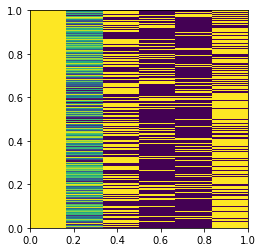

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X1,extent=[0,1,0,1])

# 5. Evaluate how well the model fitting explain the whole group's data
* For this experiment, the expected behavioral finding is an 3-way interaction between learning condition (SC/SR) and trial type (congruent, incongruent) and stimuli type (freq-inc and rare-inc)

In [7]:
gp_meanRT = pd.read_pickle('gp_meanRT.pkl')
gp_meanRT.head(10)

,bkType,conflictProb,conflict,RT,sbjId
0,SC,rare_Inc,congruent,585.715443,1
1,SC,rare_Inc,incongruent,631.808450,1
2,SC,freq_Inc,congruent,578.896330,1
3,SC,freq_Inc,incongruent,621.245219,1
4,SR,rare_Inc,congruent,564.741262,1
5,SR,rare_Inc,incongruent,629.288301,1
6,SR,freq_Inc,congruent,618.258959,1
7,SR,freq_Inc,incongruent,593.620672,1
8,SC,rare_Inc,congruent,647.556012,3
9,SC,rare_Inc,incongruent,766.827562,3


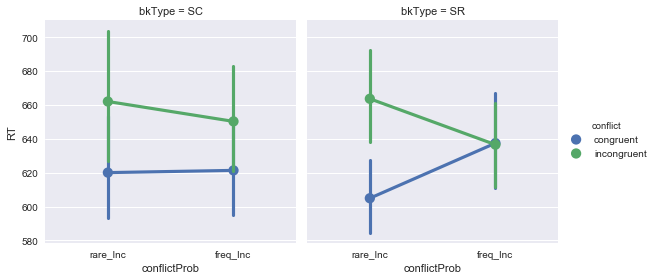

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.factorplot(x='conflictProb',y = 'RT', data=gp_meanRT, hue='conflict',col='bkType')

* The two way interaction can besummarized as one number, what we called an 'ISPC effect' for SC/SR condition

In [9]:
gp_ISPC = pd.read_pickle('gp_ISPC.pkl')
gp_ISPC.head()

,sbjId,SC_ISPC,SR_ISPC,SC_face,SC_name,SR_face,SR_name
0,1,3.744118,89.185327,-0.228430,1.891400,1.383945,5.025075
1,3,47.399978,43.686134,-0.203333,0.288874,1.121236,-0.991767
2,4,20.844006,97.353706,-0.368540,1.410079,-1.054423,4.844151
3,5,13.324552,30.969789,0.798603,0.511450,-0.718272,-0.241946
4,6,-5.709046,61.070809,-0.205837,0.702745,-2.413836,-0.563077


* To test whether subjects indeed rely on 'face' in SC condition to predict conflicts and reply on 'name' in the SR condition, we can perform the following group-level correlation between PE_weights [see step 4. above] and ISPC in SC/SR condition

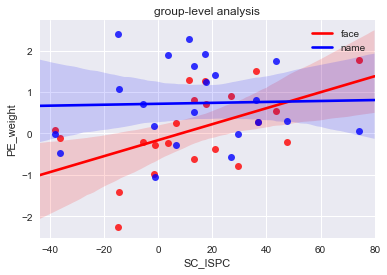

In [10]:
# For the SC condition, we expect subjects to use face to predict trial-by-trial conflict
g = sns.regplot(x = 'SC_ISPC', y = 'SC_face', data = gp_ISPC,color="r")
g = sns.regplot(x = 'SC_ISPC', y = 'SC_name', data = gp_ISPC,color="b")
g.set(xlabel= "SC_ISPC", ylabel= "PE_weight", title= "group-level analysis")
g.legend(['face','name'])
sns.plt.show()

In [11]:
import scipy
SC_face_corr = scipy.stats.pearsonr(np.array(gp_ISPC.SC_ISPC),np.array(gp_ISPC.SC_face))
SC_name_corr = scipy.stats.pearsonr(np.array(gp_ISPC.SC_ISPC),np.array(gp_ISPC.SC_name))
print('For the SC condition:')
print('p-value for correlation between ISPC and PE_face was {:.3f}'.format(SC_face_corr[1]))
print('p-value for correlation between ISPC and PE_name was {:.3f}'.format(SC_name_corr[1]))

For the SC condition:
p-value for correlation between ISPC and PE_face was 0.012
p-value for correlation between ISPC and PE_name was 0.892


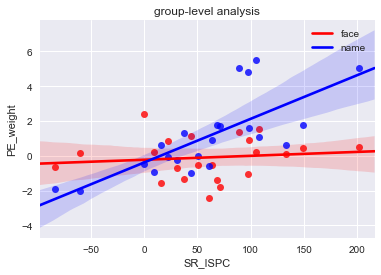

In [12]:
# For the SR condition, we expect subjects to use face to predict trial-by-trial conflict
g = sns.regplot(x = 'SR_ISPC', y = 'SR_face', data = gp_ISPC,color="r")
g = sns.regplot(x = 'SR_ISPC', y = 'SR_name', data = gp_ISPC,color="b")
g.set(xlabel= "SR_ISPC", ylabel= "PE_weight", title= "group-level analysis")
g.legend(['face','name'])
sns.plt.show()

In [13]:
SR_face_corr = scipy.stats.pearsonr(np.array(gp_ISPC.SR_ISPC),np.array(gp_ISPC.SR_face))
SR_name_corr = scipy.stats.pearsonr(np.array(gp_ISPC.SR_ISPC),np.array(gp_ISPC.SR_name))
print('For the SR condition:')
print('p-value for correlation between ISPC and PE_face was {:.3f}'.format(SR_face_corr[1]))
print('p-value for correlation between ISPC and PE_name was {:.3f}'.format(SR_name_corr[1]))

For the SR condition:
p-value for correlation between ISPC and PE_face was 0.595
p-value for correlation between ISPC and PE_name was 0.000
